# Run WEP on 2023-05-10 data (05A)

Find out why multiple iterations were needed to obtain convergence ... 

First, get the logs from EFD: 

In [64]:
from lsst.daf.butler import Butler
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline
from lsst_efd_client import EfdClient
import os
os.environ['NUMEXPR_MAX_THREADS'] = '8'
import subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval
from astropy.time import Time, TimeDelta
from astropy.table import Table
from scipy.optimize import curve_fit
from galsim.zernike import zernikeRotMatrix

from numexpr.utils import log as numexpr_logger
from logging import WARN
numexpr_logger.setLevel(WARN)

import pandas as pd
import warnings
# to prevent butler from displaying the username
# with INFO:botocore.credentials
warnings.filterwarnings('ignore') 

In [65]:
efd_client = EfdClient('usdf_efd')

In [66]:
spans = []

day_obs = '20230509'
butler = Butler('/sdf/data/rubin/repo/embargo/')
datasetRefs = butler.registry.queryDatasets('raw',collections='LATISS/raw/all',
                              where=f"instrument='LATISS' AND exposure.day_obs = {day_obs}").expanded()


for i, ref in enumerate(datasetRefs):
    record = ref.dataId.records["exposure"]
    exp = record.dataId['exposure']
    spans.append(record.timespan)

# also add those refs from the next day
day_obs = '20230510'
datasetRefs = butler.registry.queryDatasets('raw',collections='LATISS/raw/all',
                              where=f"instrument='LATISS' AND exposure.day_obs = {day_obs}").expanded()
for i, ref in enumerate(datasetRefs):
    record = ref.dataId.records["exposure"]
    exp = record.dataId['exposure']
    spans.append(record.timespan)
    #print(exp, record.group_id, record.group_name)

In [5]:
t1 = spans[0].begin.utc # need to use UTC scale 
t2 = spans[-1].end.utc

In [6]:
t1

<Time object: scale='utc' format='iso' value=2023-05-09 19:33:43.001004>

In [7]:
t2

<Time object: scale='utc' format='iso' value=2023-05-11 06:18:11.460000>

In [8]:
end_readout = await efd_client.select_time_series("lsst.sal.ATCamera.logevent_endReadout", 
                                          '*', t1, t2)

In [10]:
keys = end_readout['additionalKeys'][0].split(':')
print(keys)
key_dict = {}
for key in keys:
    key_dict[key] = np.empty(len(end_readout), dtype="<U25")

for i in range(len(end_readout)):
    values = end_readout['additionalValues'][i].split(':')
    #print(i,values)
    key_dict['imageType'][i]=values[0] # cwfs is what we want 
    key_dict['groupId'][i]=''.join(values[1:4])  
    key_dict['testType'][i]=values[4]
    key_dict['stutterRows'][i]=values[5]
    key_dict['stutterNShifts'][i]=values[6]
    key_dict['stutterDelay'][i]=values[7]
   

['imageType', 'groupId', 'testType', 'stutterRows', 'stutterNShifts', 'stutterDelay']


In [12]:
for key in key_dict.keys():
    end_readout[key] = key_dict[key]

In [13]:
np.unique(end_readout['imageType'])

array(['ACQ', 'BIAS', 'CWFS', 'DARK', 'ENGTEST', 'FLAT', 'OBJECT'],
      dtype=object)

In [14]:
np.unique(end_readout['testType'])

array(['ACQ', 'BIAS', 'CWFS', 'DARK', 'ENGTEST', 'FLAT', 'OBJECT'],
      dtype=object)

In [21]:
#m = end_readout['imageType']=='CWFS'
#end_readout[m][:25]
end_readout[:4]

,additionalKeys,additionalValues,imageController,imageDate,imageIndex,imageName,imageNumber,imageSource,imagesInSequence,private_efdStamp,...,private_sndStamp,requestedExposureTime,timestampAcquisitionStart,timestampEndOfReadout,imageType,groupId,testType,stutterRows,stutterNShifts,stutterDelay
2023-05-09 19:33:45.421611+00:00,imageType:groupId:testType:stutterRows:stutter...,BIAS:2023-05-09T19\:34\:19.899:BIAS:0:0:0.0,O,20230509,1,AT_O_20230509_000001,1,AT,1,1.683661e+09,...,1.683661e+09,0.0,1.683586e+09,1.683661e+09,CWFS,2023-05-09T19\34\19.899,BIAS,0,0,0.0
2023-05-09 19:33:55.804663+00:00,imageType:groupId:testType:stutterRows:stutter...,ENGTEST:2023-05-09T19\:34\:26.422:ENGTEST:0:0:0.0,O,20230509,1,AT_O_20230509_000002,2,AT,1,1.683661e+09,...,1.683661e+09,2.0,1.683661e+09,1.683661e+09,CWFS,2023-05-09T19\34\26.422,ENGTEST,0,0,0.0
2023-05-09 19:51:59.577059+00:00,imageType:groupId:testType:stutterRows:stutter...,BIAS:2023-05-09T19\:52\:33.975:BIAS:0:0:0.0,O,20230509,1,AT_O_20230509_000003,3,AT,1,1.683662e+09,...,1.683662e+09,0.0,1.683661e+09,1.683662e+09,CWFS,2023-05-09T19\52\33.975,BIAS,0,0,0.0
2023-05-09 19:52:08.336391+00:00,imageType:groupId:testType:stutterRows:stutter...,ENGTEST:2023-05-09T19\:52\:40.324:ENGTEST:0:0:0.0,O,20230509,1,AT_O_20230509_000004,4,AT,1,1.683662e+09,...,1.683662e+09,2.0,1.683662e+09,1.683662e+09,CWFS,2023-05-09T19\52\40.324,ENGTEST,0,0,0.0


In [15]:
intra_images = []
extra_images = []
intra_times = []
extra_times = []
intra_exptimes = []
extra_exptimes = []

i = 0
npairs = 0
nmiss = 0

groupCol = 'groupId' # 'groupName'
expTimeCol = 'requestedExposureTime'  # 'requestedExposureTime' 

while i < len(end_readout)-2:
    intra = end_readout['imageName'][i]
    extra = end_readout['imageName'][i+1]
    
    # assume has `imageType` and `groupId` cols 
    if (end_readout['imageType'][i] == 'CWFS') and (end_readout['testType'][i] == 'CWFS'):

        print(f"CWFS pair: {intra} x {extra},          ")

        intra_images.append(intra)
        extra_images.append(extra)
        intra_times.append(end_readout.index[i])
        extra_times.append(end_readout.index[i+1])
        intra_exptimes.append(end_readout[expTimeCol][i])
        extra_exptimes.append(end_readout[expTimeCol][i+1])
        i+=2
        npairs+=1
    else :
        #print(f"No Match: {intra} x {extra}")
        nmiss+=1
        i+=1

print(f"Got {npairs} pairs and {nmiss} misses.")

CWFS pair: AT_O_20230509_000170 x AT_O_20230509_000171,          
CWFS pair: AT_O_20230509_000172 x AT_O_20230509_000173,          
CWFS pair: AT_O_20230509_000174 x AT_O_20230509_000175,          
CWFS pair: AT_O_20230509_000176 x AT_O_20230509_000177,          
CWFS pair: AT_O_20230509_000178 x AT_O_20230509_000179,          
CWFS pair: AT_O_20230509_000180 x AT_O_20230509_000181,          
CWFS pair: AT_O_20230509_000183 x AT_O_20230509_000184,          
CWFS pair: AT_O_20230509_000186 x AT_O_20230509_000187,          
CWFS pair: AT_O_20230509_000188 x AT_O_20230509_000189,          
CWFS pair: AT_O_20230509_000191 x AT_O_20230509_000192,          
CWFS pair: AT_O_20230509_000193 x AT_O_20230509_000194,          
CWFS pair: AT_O_20230509_000195 x AT_O_20230509_000196,          
CWFS pair: AT_O_20230509_000406 x AT_O_20230509_000407,          
CWFS pair: AT_O_20230509_000408 x AT_O_20230509_000409,          
CWFS pair: AT_O_20230509_000410 x AT_O_20230509_000411,          
CWFS pair:

In [27]:
i=0
t1 = Time(intra_times[i]) - TimeDelta(intra_exptimes[i], format='sec') - TimeDelta(15., format='sec')
exp_start = Time(intra_times[i]) - TimeDelta(intra_exptimes[i], format='sec')
exp_end = Time(intra_times[i])
#- TimeDelta(180., format='sec', scale='tai')
#t2 = Time(intra_times[i])
t2 = Time(extra_times[5]) + TimeDelta(30., format='sec')
extra_exp_start = Time(extra_times[i])  - TimeDelta(extra_exptimes[i], format='sec')
extra_exp_end = Time(extra_times[i])
azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                           ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], t1, t2)

rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                              ["nasmyth2CalculatedAngle99"], t1, t2)

In [28]:
log = await efd_client.select_time_series("lsst.sal.Script.logevent_logMessage",
                                     ["message", "salIndex"], t1,t2    )

In [91]:
for i in range(len(log)):
    print(log['message'][i])

LATISS Wavefront Estimation Pipeline initialized. Perform optical alignment procedure of the Rubin Auxiliary Telescope with LATISS using the Wavefront Estimation Pipeline task.
Read historical data in 0.00 sec
Check ATAOS corrections are enabled.
No target configured.
CWFS iteration 1 starting...
Moving to intra-focal position
Taking intra-focal image
imagetype: CWFS, skip TCS synchronization.
Moving to extra-focal position
Taking extra-focal image
imagetype: CWFS, skip TCS synchronization.
Intra/extra exposure ids: 2023050900170/2023050900171
Angle used in cwfs algorithm is -152.35
Moving hexapod back to zero offset (in-focus) position
Running wep with: intra_visit_id=2023050900170, extra_visit_id=2023050900171, donut_diameter=228, timeout_get_image=20.0. 
Error in run
Setting final state to <ScriptState.FAILED: 10>
LATISS Wavefront Estimation Pipeline initialized. Perform optical alignment procedure of the Rubin Auxiliary Telescope with LATISS using the Wavefront Estimation Pipeline 

ok, given the log, let's run WEP with all these image pairs, and compare what I get ... 

preview the exposure pairs : 

In [38]:
int(intra_images[0].split('_')[-1])

170

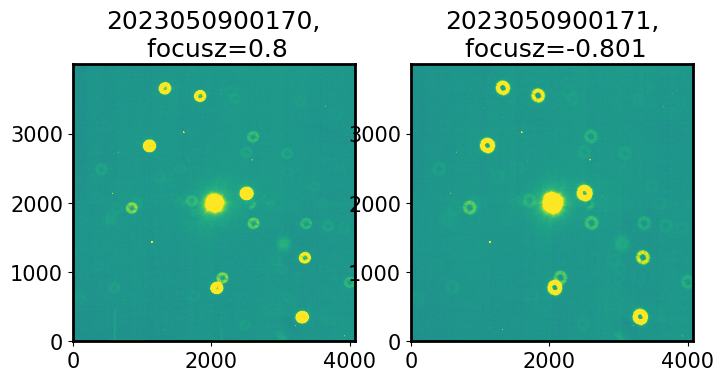

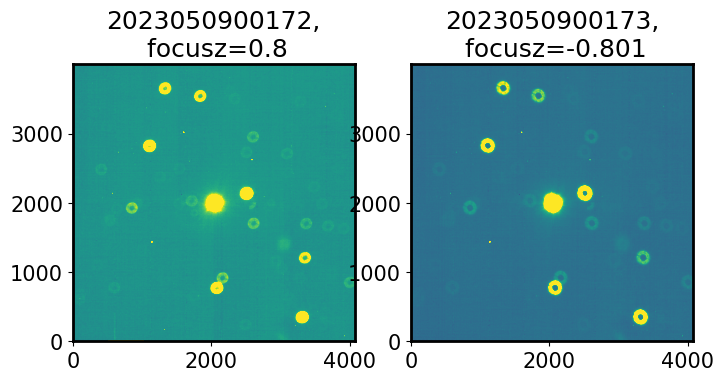

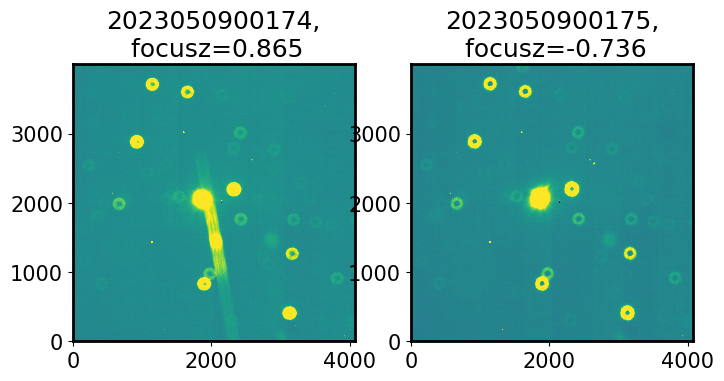

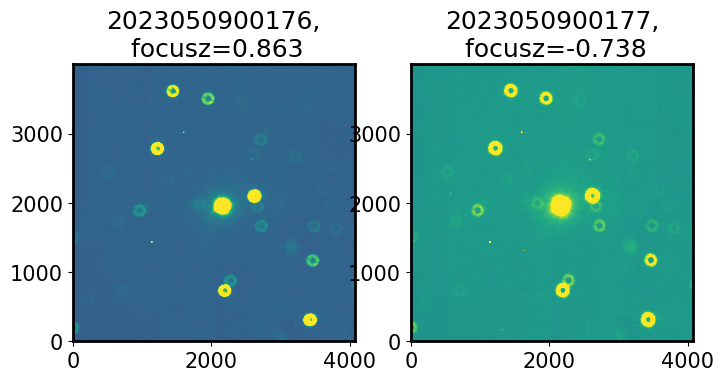

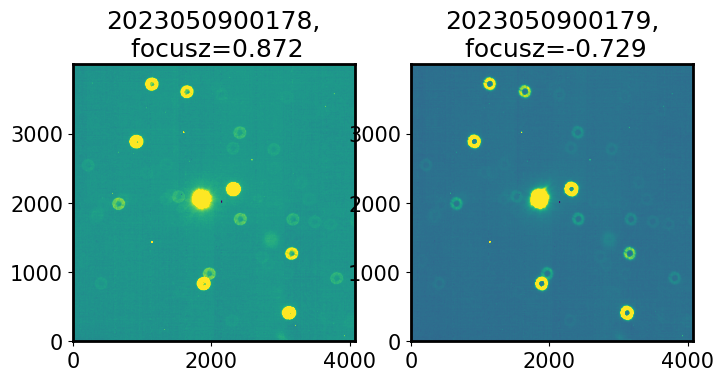

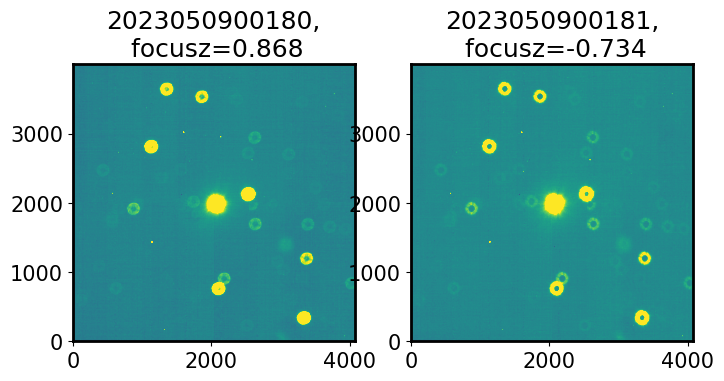

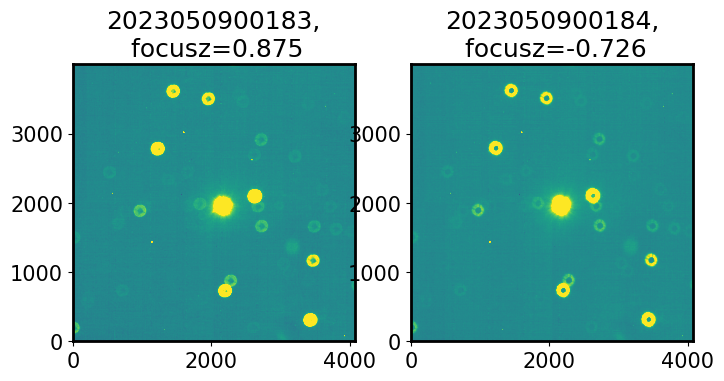

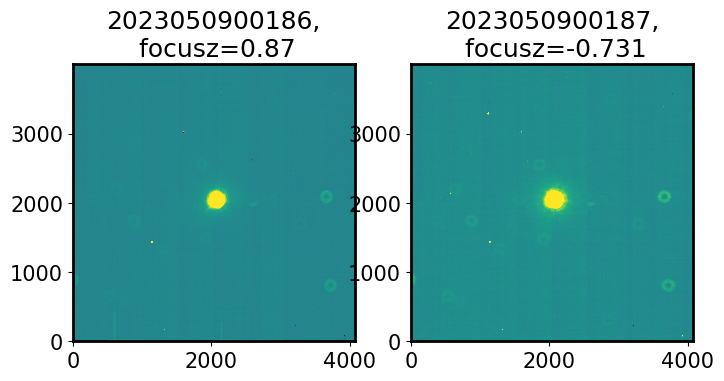

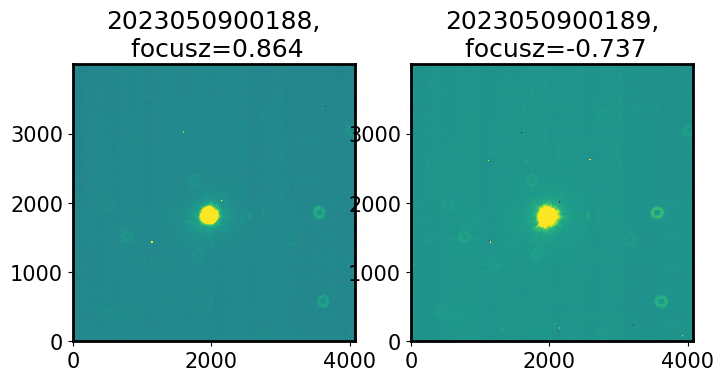

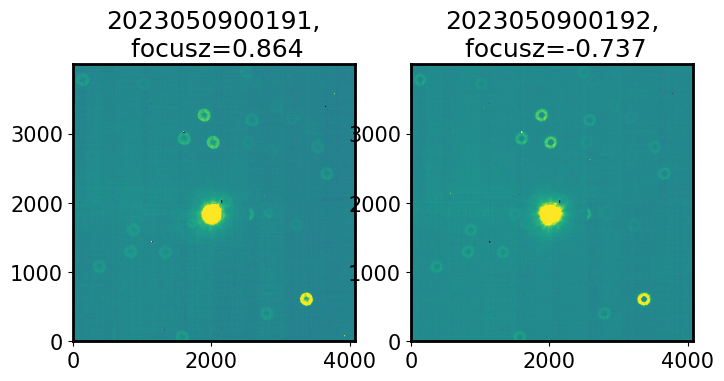

In [40]:
import analysis_tools as at 

for i in range(10):
    day = int(intra_images[i].split('_')[2])
    seqNum1 = int(intra_images[i].split('_')[-1])
    seqNum2 = int(extra_images[i].split('_')[-1])
    at.preview_auxtel_pair(day=day,
        seqNums=[seqNum1, seqNum2],
        datasetRefOrType='quickLookExp',
        collections=['LATISS/runs/quickLook'],
        repo='/repo/embargo',)

Apart from 174,175, these exposure pairs look ok to me ... 

# Try to run WEP for all using quickLookExp

Find image pairs

In [67]:
from lsst.daf.butler import Butler

butler = Butler(
    "/repo/embargo",
    collections=['LATISS/runs/quickLook'],
    instrument='LATISS'
)

records = list(
    butler.registry.queryDimensionRecords(
        "exposure",
        where="exposure.observation_type='cwfs' and exposure.day_obs >= 20230509 and exposure.day_obs <= 20230510"
    )
)
records.sort(key=lambda record: (record.day_obs, record.seq_num))
print(len(records))

# Loop through and make pairs where 1st exposure is intra and second exposure is extra and have same group_id
pairs = []
for record0, record1 in zip(records[:-1], records[1:]):
    if (
        record0.observation_reason.startswith('intra') and
        record1.observation_reason.startswith('extra') 
        and record0.seq_num >= 1
        and record1.seq_num <= 560
    ):
        pairs.append((record0, record1))
print(len(pairs))


82
41


Ok, I also get exactly the same number of CWFS pairs (41) spanning that night (dates 2023-05-09, 2023-05-10). 

Run by hand  - but instead of `bps` or that weird `simplePipelineExecutor`, submit pipetasks from here. Choose just one pair to run in-detail comparison : 

In [123]:
record0, record1  = pairs[2]
print(record0.id, record1.id)

2023050900174 2023050900175


In [125]:
from lsst.ts.wep.utility import runProgram 


path_to_pipeline = os.path.join(os.getcwd(), 
             'latissWepPipeline_230310_getZernikes_withTranspose_quickLookExp.yaml' ) 
             
path_to_pipeline2 = os.path.join(os.getcwd(), 
             'latissWepPipeline_230310_getZernikes_noTranspose_quickLookExp.yaml' ) 


# call that test : with image transpose (default)
# that's also use by latiss_wep_align, since the 
# config.transposeImages = False is NOT set .... 
#     
#     config = CalcZernikesTaskConfig()
#     # LATISS config parameters
#     config.opticalModel = "onAxis"
#     config.instObscuration = 0.3525
#     config.instFocalLength = 21.6
#     config.instApertureDiameter = 1.2
#     config.instDefocalOffset = 32.8
#     task = CalcZernikesTask(config=config, name="Base Task")

cmd = f'pipetask run  --instrument lsst.obs.lsst.Latiss \
--data-query "exposure IN ({record0.id}..{record1.id})" \
-b /sdf/data/rubin/repo/embargo/butler.yaml \
--input LATISS/runs/quickLook  \
--output u/scichris/latiss_230510_run/test \
--pipeline {path_to_pipeline} --register-dataset-types'
print(cmd)

# call that test2: no image transpose 
cmd = f'pipetask run  --instrument lsst.obs.lsst.Latiss \
--data-query "exposure IN ({record0.id}..{record1.id})" \
-b /sdf/data/rubin/repo/embargo/butler.yaml \
--input LATISS/runs/quickLook  \
--output u/scichris/latiss_230510_run/test2 \
--pipeline {path_to_pipeline2} --register-dataset-types'
print(cmd)

pipetask run  --instrument lsst.obs.lsst.Latiss --data-query "exposure IN (2023050900174..2023050900175)" -b /sdf/data/rubin/repo/embargo/butler.yaml --input LATISS/runs/quickLook  --output u/scichris/latiss_230510_run/test --pipeline /sdf/data/rubin/user/scichris/WORK/AOS/latissWepPipeline_230310_getZernikes_withTranspose_quickLookExp.yaml --register-dataset-types
pipetask run  --instrument lsst.obs.lsst.Latiss --data-query "exposure IN (2023050900174..2023050900175)" -b /sdf/data/rubin/repo/embargo/butler.yaml --input LATISS/runs/quickLook  --output u/scichris/latiss_230510_run/test2 --pipeline /sdf/data/rubin/user/scichris/WORK/AOS/latissWepPipeline_230310_getZernikes_noTranspose_quickLookExp.yaml --register-dataset-types


In [117]:
runProgram(cmd)

lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 5 quanta for 3 tasks, graph ID: '1683836884.8108802-2367009'
Quanta             Tasks            
------ -----------------------------
     2 generateDonutDirectDetectTask
     1 cutOutDonutsScienceSensorTask
     2              calcZernikesTask
lsst.generateDonutDirectDetectTask.measurementTask INFO: Found 10 sources in exposure
lsst.generateDonutDirectDetectTask.measurementTask INFO: Measured 10 of 10 sources in exposure
lsst.generateDonutDirectDetectTask INFO: Running Donut Selector
lsst.generateDonutDirectDetectTask.donutSelector INFO: Selected 1/10 references
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'generateDonutDirectDetectTask' on quantum {instrument: 'LATISS', detector: 0, visit: 2023050900174, ...} took 2.954 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 1 quanta successfully, 0 failed and 4 remain out of total 5 quanta.
lsst.generateDonutDirectDetectTask.measurementTask INFO: Found 10 sou

Read the results: 

In [92]:
butler = Butler("/repo/embargo",instrument='LATISS')
collection = 'u/scichris/latiss_230510_run/test'
dataId  = {'instrument':'LATISS', 'detector':0, 'visit':record1.id}
zk =  butler.get('zernikeEstimateRaw', dataId=dataId, collections=[collection])

In [121]:
butler = Butler("/repo/embargo",instrument='LATISS')
collection2 = 'u/scichris/latiss_230510_run/test2'
dataId  = {'instrument':'LATISS', 'detector':0, 'visit':record1.id}
zk2 =  butler.get('zernikeEstimateRaw', dataId=dataId, collections=[collection2])

`test` had image transpose. Then we need to swap comaX with comaY , i.e. 

`comaX, comaY, defocus ` is  `np.round(zk[0][[4,3,0]]*1000,1)` (that's what `latiss_wep_align` does, but it also takes the -ve value of zernikes[4], i.e. -comaX ...  (!) 

Without the transpose we would have  `comaX, comaY, defocus ` as  `np.round(zk[0][[3,4,0]]*1000,1)`, i.e. correct order. Show below plotting elements  `[4,3,0]`   of  `zk` , and  `[3,4,0]` of `zk2`. 
 


In [127]:
np.round(zk[0][[4,3,0]]*1000,1)

array([ 13.4, -40.6,  -2.9])

In [128]:
np.round(zk2[0][[3,4,0]]*1000,1)

array([ 13.4, -40.6,  -2.9])

compare that directly to 

    Intra/extra exposure ids: 2023050900174/2023050900175
    Angle used in cwfs algorithm is -152.26
    Moving hexapod back to zero offset (in-focus) position
    Running wep with: intra_visit_id=2023050900174, extra_visit_id=2023050900175, donut_diameter=228, timeout_get_image=20.0. 
    ==============================
    Measured [coma-X, coma-Y, focus] zernike coefficients [nm]: [-13.4, -40.6, -2.9, ]
    De-rotated [coma-X, coma-Y, focus]  zernike coefficients [nm]: [30.7, 29.7, -2.9, ]
    Hexapod [x, y, z] offsets [mm] : 0.222, -0.196, -0.001, 
    Telescope offsets [arcsec]: 11.6, -9.9, 0.0, 
    ==============================

    Applying offset: x=0.222, y=-0.196, z=-0.001.
    Applying telescope offset [az,el]: [11.625, -9.868].
    Calculating Az/El offset: 11.624728261183114/-9.867775568511679 
    Persistent x/y offset: -14.882647791941185/3.3187492399838696

so the measurement is the same except that we're reporting wrong coefficients (comaX is reported as comaY and vice-versa...)




It should be that 

    [coma-X, coma-Y, focus] are np.round(zk[0][[3,4,0]]*1000,1)   i.e.   no transpose

Show the donut stamps to prove there's nothing weird: 

In [102]:
stamps_intra = butler.get('donutStampsIntra', dataId=dataId, collections=[collection])   #donutStampsExtra

In [104]:
stamps_extra = butler.get('donutStampsExtra', dataId=dataId, collections=[collection])   #donutStampsExtra

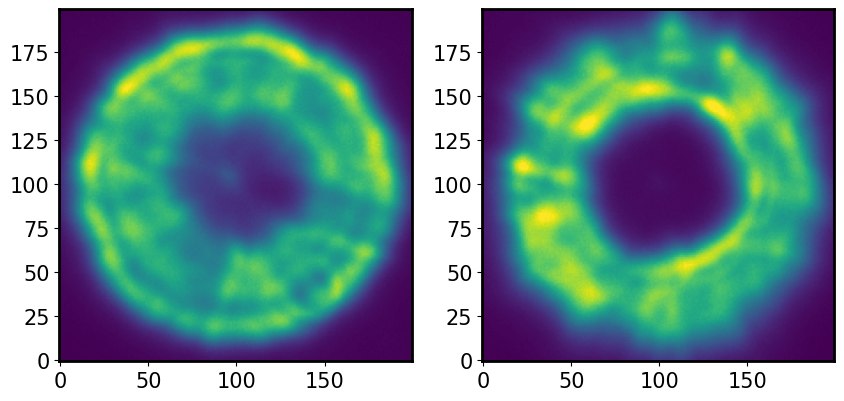

In [106]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
zscale = ZScaleInterval()
i=0
for stamp in [stamps_intra, stamps_extra]:
    data = stamp[0].stamp_im.image.array
    vmin,vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    i+=1


Then we apply derotation:

In [107]:
matrix_rotation = lambda angle: np.array(
            [
                [np.cos(np.radians(angle)), -np.sin(np.radians(angle)), 0.0],
                [np.sin(np.radians(angle)), np.cos(np.radians(angle)), 0.0],
                [0.0, 0.0, 1.0],
            ]
        )


In [108]:
old_matrix_sensitivity =  [
            [1.0 / 206.0, 0.0, 0.0],
            [0.0, -1.0 / 206.0, -(109.0 / 206.0) / 4200],
            [0.0, 0.0, 1.0 / 4200.0],
        ]
new_matrix_sensitivity = [
            [0.00688945, -0.00008867, 0.00004848],
           [0.00031787, -0.00650340, -0.00007319],
           [-0.00000782, -0.00003023, 0.00025634]]


In [115]:
angle = -152.26
zern = zk[0][[4,3,0]]*1000 # in comaX, comaY, defocus in nm 
print(zern)# should be  [-13.4, -40.6, -2.9, ] 
camera_rotation_angle = 0 
# camera_rotation_angle is orientation of the 
# detector relative to the rotator, 
# assumed to be within a degree or two 
rot_zern = np.matmul(
            zern, matrix_rotation(-angle + camera_rotation_angle)
        )
print(rot_zern) # should be [30.7, 29.7, -2.9, ] 
hexapod_offset_old = np.matmul(rot_zern, old_matrix_sensitivity)
hexapod_offset_new = np.matmul(rot_zern, new_matrix_sensitivity)

[ 13.36189206 -40.64281047  -2.8692489 ]
[-30.7437997   29.75226011  -2.8692489 ]


In [110]:
hexapod_offset_old

array([ 0.03442432, -0.20481123, -0.00599849])

In [111]:
hexapod_offset_new


array([ 0.06228964, -0.27492775, -0.00347968])

## [Aside : simplePipelineExecutor doesn't store intermediate seqNums ...]

In [ ]:
repo_dir = '/sdf/data/rubin/repo/embargo/'
user = os.getlogin()
input_collections = ['LATISS/runs/quickLook']
output_collection = f'u/{user}/latiss_202305A_run/bestEffortIsr_t'


butler = Butler(repo_dir)
registry = butler.registry
collections_list = list(registry.queryCollections())

# skip if collection already exists
if output_collection in collections_list:
    print(f'{output_collection} already exists, skipping')
    
else: 
    butlerRW = SimplePipelineExecutor.prep_butler(repo_dir, 
                                                  inputs=input_collections, 
                                                  output=output_collection)
    path_to_pipeline_yaml = os.path.join(os.getcwd(), 
             'latissWepPipeline_230310_getZernikes_withTranspose_quickLookExp.yaml' ) 

    # Load pipeline from file
    pipeline = Pipeline.from_uri(path_to_pipeline_yaml)

    # run the pipeline for each CWFS pair... 
    for i in range(3):
        first  = ''.join(intra_images[i].split('_')[2:4]) # '20230509000170' 
        second = ''.join(extra_images[i].split('_')[2:4]) # '20230509000171' 

        data_query = f"exposure in ({first}..{second})"
        executor = SimplePipelineExecutor.from_pipeline(pipeline, 
                                                        where=data_query, 
                                                        butler=butlerRW)
        quanta = executor.run(True)

### [ Aside: bps is down ]

In [ ]:
import subprocess
from lsst.daf.butler import Butler

butler = Butler(
    "/repo/embargo",
    collections=['LATISS/runs/quickLook'],
    instrument='LATISS'
)

records = list(
    butler.registry.queryDimensionRecords(
        "exposure",
        where="exposure.observation_type='cwfs' and exposure.day_obs >= 20230509 and exposure.day_obs <= 20230510"
    )
)
records.sort(key=lambda record: (record.day_obs, record.seq_num))
print(len(records))

# Loop through and make pairs where 1st exposure is intra and second exposure is extra and have same group_id
pairs = []
for record0, record1 in zip(records[:-1], records[1:]):
    if (
        record0.observation_reason.startswith('intra') and
        record1.observation_reason.startswith('extra') 
        and record0.seq_num >= 1
        and record1.seq_num <= 560
    ):
        pairs.append((record0, record1))
print(len(pairs))


for record0, record1 in pairs[:3]:
    day_obs = record0.day_obs
    first = record0.seq_num
    second = record1.seq_num
    cmd = "bps submit "
    cmd += f"-d \"exposure.observation_type='cwfs' and exposure.day_obs={day_obs} and exposure.seq_num in ({first}..{second})\" "
    cmd += " bps_wep_test.yaml"
    print()
    print(cmd)
    subprocess.run(cmd, shell=True)